### 参考github
https://github.com/rasbt/LLMs-from-scratch/blob/main/ch04/01_main-chapter-code/ch04.ipynb

In [1]:
from importlib.metadata import version

print("matplotlib version:", version("matplotlib"))
print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

matplotlib version: 3.9.4
torch version: 2.7.1
tiktoken version: 0.9.0


# GPTモデルの実装

In [6]:
# ch03のコピー
import torch
import torch.nn as nn

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), "d_outはnum_headsで割りける値を設定"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        # 重みパラメータの初期化
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

        # headの結合
        self.out_proj = nn.Linear(d_out,d_out)
        # ドロップアウト
        self.dropout = nn.Dropout(dropout)
        # マスク（causal attention）: context_lengthは最大長
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length,context_length),diagonal=1) # 上三角行列（対角は０）で１の部分がマスクされる
        )

    def forward(self, x):
        # バッチ、トークン数、埋め込み次元
        b, num_tokens, d_in = x.shape

        # クエリ、キー、バリュー
        ## テンソルの形状：b x num_tokens x d_out ← 計算するためにd_outをnum_heads x head_dimに分解する必要あり
        queries = self.W_query(x)
        keys = self.W_key(x)
        values = self.W_value(x)

        ## テンソルの形状を b x num_tokens x num_heads x head_dimに
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        ## num_tokensとhead_dimがテンソルの後ろに移動し、行列計算できるようにする
        keys = keys.transpose(1,2) # 要素番号1,2の位置を入れ替え
        values = values.transpose(1,2)
        queries = queries.transpose(1,2)

        # アテンションスコアの計算
        attn_scores = queries @ keys.transpose(2,3) # 内積計算するためにkeysの方はnum_tokensとhead_dimを入れ替えて転置
        
        # causal attention
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens] # マスクをトークン数で切り捨て
        attn_scores.masked_fill_(mask_bool,-torch.inf)

        # 正規化
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        # ドロップアウト
        attn_weights = self.dropout(attn_weights)

        # コンテキストベクトル
        context_vec = (attn_weights @ values).transpose(1,2) # b x num_tokens x num_heads x head_dimにもどす
        ## テンソルの形状を出力に直す（各ヘッドの計算結合をマージ）
        context_vec = context_vec.contiguous().view(
            b, num_tokens, self.d_out
        )
        ## 線形射影を追加　※厳密には必要ないが多くのLLMアーキテクチャで一般的に使われているため参考として追加しているそう
        context_vec = self.out_proj(context_vec)
        return context_vec


### 

In [5]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # 語彙サイズ
    "context_length": 1024, # コンテキストの長さ
    "emb_dim": 768,         # 埋め込み次元
    "n_heads": 12,          # Attentionヘッドの数
    "n_layers": 12,         # Transformerブロックの数
    "drop_rate": 0.1,       # ドロップアウト率
    "qkv_bias": False       # クエリ、キー、バリューの計算（torch.nn.Linear）の計算にバイアスを使うか
}

In [8]:
# 層正規化クラス
'''
Note
層正規化は勾配消失や勾配爆発に対応するための工夫。
層の出力を平均０、分散１になるように調整することで、効果的な重みへの収束が早まり、訓練の一貫性と信頼性が確保される。
Multi-head Attentionの前（または後）、出力層
'''
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5 # 0除算の防止
        # 訓練可能なパラメータを用意(入力次元と同次元)
        self.scale = nn.Parameter(torch.ones(emb_dim)) # 平均１
        self.shift = nn.Parameter(torch.zeros(emb_dim)) # 分散０

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True) # dim=-1により列次元（テンソルの最後）に沿って計算。keepdim=Trueにすることで、テンソルが縮小しても出力テンソルの次元数が常に入力テンソルに一致する
        var = x.var(dim=-1, keepdim=True, unbiased=False) # unbaised=Trueだと普遍分散。nが大きければn, n-1で変わらないので計算結果は同じ
        norm_x = (x - mean) / torch.sqrt(var + self.eps)

        # 訓練可能なパラメータを用意しておくことで訓練時にデータに合わせて最適に自動調整されるようにする
        return self.scale * norm_x + self.shift

In [9]:
# GELU活性化関数
'''
GELUはReLUをより複雑で滑らかに改善したもの
'''
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

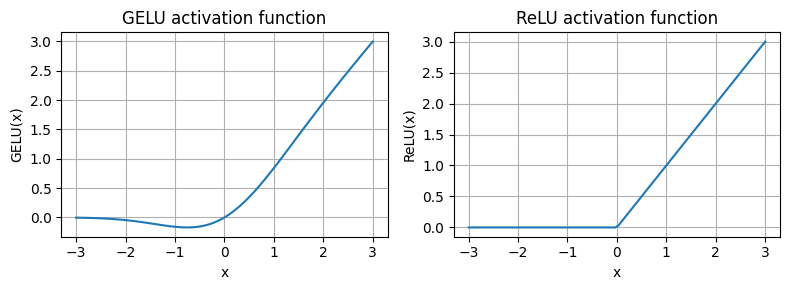

In [10]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

# Some sample data
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

In [12]:
# feedfowardモジュール
'''
汎化性能の向上
Linear（高次元に射影） + GELU活性化 + Linear (入力次元に戻す)
'''
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]), # 高次元に射影
            GELU(), # 活性化関数 
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]), # 入力次元に戻す
        )

    def forward(self, x):
        return self.layers(x)

In [14]:
# Transformerブロック

class TransformerBlock(nn.Module):
    def __init__(self, cfg, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # multi head attention
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], 
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"]
            )
        
        # feedforward
        self.ff = FeedForward(cfg)

        # 層正規化x２
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])

        # ドロップアウト
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # アテンンションブロック
        shortcut = x # ショートカットは勾配消失を防ぐための工夫。ある層の出力を１つ以上先の層の出力に追加する。
        x = self.norm1(x) # 層正規化はコンポーネントの前に配置。後ろに配置すると悪さすることもあるらしい。
        x = self.att(x) # アテンション機構
        x = self.drop_shortcut(x) # ドロップアウト
        x = x + shortcut

        # feefforwardブロック
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x) # feefforward
        x = self.drop_shortcut(x)
        x = x + shortcut

        return x

<img src="fig/ch04_GPTModel.png" width="700">

In [15]:
# GPTモデル
class GPTModel(nn.Module):
    def __init__(self, cfg, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        # トークン埋め込み＋位置埋め込み
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])

        # ドロップアウト
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        # transformerブロック x 12
        ## *はリストの中身を個別に渡すため。nn.Sequential(*[l1,l2,l3])はnn.Sequential(l1,l2,l3)と等価。*がない場合リストがレイヤー１つとみなされてしまう。
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )

        # 最後の層正規化
        self.final_norm = LayerNorm(cfg["emb_dim"])

        # 線形出力層：各トークンベクトルを語彙サイズと同じ次元に変換する
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )
        

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        # トークン埋め込み
        tok_embeds = self.tok_emb(in_idx)
        # 位置埋め込み
        ## torch.arange(3) → tensor([0,1,2])で位置を表すベクトルを作る
        pos_embeds = self.pos_emb(
            torch.arange(seq_len, device=in_idx.device)
        )

        # 各層の出力を計算
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)

        return logits





In [17]:
# バッチ
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

batch = []

txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [18]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.3613,  0.4223, -0.0711,  ...,  0.3483,  0.4661, -0.2838],
         [-0.1792, -0.5660, -0.9485,  ...,  0.0477,  0.5181, -0.3168],
         [ 0.7120,  0.0332,  0.1085,  ...,  0.1018, -0.4327, -0.2553],
         [-1.0076,  0.3418, -0.1190,  ...,  0.7195,  0.4023,  0.0532]],

        [[-0.2564,  0.0900,  0.0335,  ...,  0.2659,  0.4454, -0.6806],
         [ 0.1230,  0.3653, -0.2074,  ...,  0.7705,  0.2710,  0.2246],
         [ 1.0558,  1.0318, -0.2800,  ...,  0.6936,  0.3205, -0.3178],
         [-0.1565,  0.3926,  0.3288,  ...,  1.2630, -0.1858,  0.0388]]],
       grad_fn=<UnsafeViewBackward0>)


# テキスト生成
<img src="fig/ch04_gpt_text_gen.png" width="700">

In [24]:
# テキスト生成するGPTモデルの関数
def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        # トークン数がコンテキストサイズを超える場合にコンテキストを切り詰める。
        idx_cond = idx[:, -context_size:]

        # GPTモデルの出力
        with torch.no_grad():
            # gptの出力はバッチ x トークン数 x 語彙サイズのテンソル
            logits = model(idx_cond)
        
        # 最後のベクトルを抽出
        ## 最後のベクトルがGPTが予測した次のトークンベクトル
        ## (バッチサイズ、トークン数、語彙サイズ)　→　(バッチ、語彙サイズ)に変換される
        logits = logits[:,-1,:]

        # softmaxで確率に変換
        probas = torch.softmax(logits, dim=-1)

        # 確率が最も高い要素（トークンID）を抽出
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)

        # 次のトークン予測のために入力を更新
        idx = torch.cat((idx, idx_next), dim=1)


    # 次のトークンIDを返す
    return idx

In [25]:
start_context = "Hello, I am"

encoded = tokenizer.encode(start_context)
print("encoded:", encoded)

# バッチの軸を追加したテンソルに変換
## unsqueeze(0) 0番目に軸を追加
## １次元ベクトル　→　1x4のテンソルに変換
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [26]:
# 評価モードに切り替え
## 訓練時のみ使われるドロップアウトのようなランダムなコンポーネントが無効になる

model.eval()

out = generate_text_simple(
    model=model,
    idx=encoded_tensor,
    max_new_tokens=6,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output: ", out)
print("Output length: ", len(out[0]))


Output:  tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length:  10


In [27]:
# トークンIDを文章に直す
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)


Hello, I am Featureiman Byeswickattribute argue
